In [227]:
#Source: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

import warnings
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import statsmodels.api as sm
import pickle
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import date2num
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline
import json
plt.close("all")

import sys
!{sys.executable} -m pip install statsmodels

euroData = pd.read_csv("data\euro_countries_padded.csv")
with open("data/iso_country_codes.json", "r") as read_file:
    countryCodes = json.load(read_file)

warnings.filterwarnings("ignore")

## Creating Datasets

In [228]:
def europe_set(smoothed = False, beg_date='2020-01-01', end_date=euroData["date"].iloc[-1]):
    """For entire Europe.
    :param smoothed: True->Uses new_cases_smoothed as the source for new cases (7-day average)
                     False->Uses raw data from new_cases
    :param beg_date: beginning of the dataset
    :param end_date: end of the dataset   
    """
    if (smoothed):
        df = euroData.groupby("date")["new_cases_smoothed"].sum().reset_index(name = "new_cases")
    else:
        df = euroData.groupby("date")["new_cases"].sum().reset_index(name = "new_cases")
    df['date'] = pd.to_datetime(df['date'])
    # Set the date as index 
    df = df.set_index('date')
    # Select the proper time period for weekly aggreagation
    df = df[beg_date:end_date]
    return df


def country_set(iso_code, smoothed = False, beg_date='2020-01-01', end_date=euroData["date"].iloc[-1]):
    """For specific country.
    :param iso_code: The county's ISO-code (3 letters)
    :param smoothed: True->Uses new_cases_smoothed as the source for new cases (7-day average)
                     False->Uses raw data from new_cases
    :param beg_date: beginning of the dataset
    :param end_date: end of the dataset   
    """
    if (smoothed):
        df = euroData[euroData.iso_code==iso_code].groupby("date")["new_cases_smoothed"].sum().reset_index(name = "new_cases")
    else:
        df = euroData[euroData.iso_code==iso_code].groupby("date")["new_cases"].sum().reset_index(name = "new_cases")
        
    df['date'] = pd.to_datetime(df['date'])
    # Set the date as index 
    df = df.set_index('date')
    # Select the proper time period for weekly aggreagation
    df = df[beg_date:end_date]
    return df

## Visualizing the data 

In [229]:
df_eu = europe_set()
df_nor = country_set("NOR")
df_esp = country_set("ESP")
df_deu = country_set("DEU")

In [230]:
def Initial_plot(df, country_name ='Europe'):
    y = df['new_cases']
    fig, ax = plt.subplots(figsize=(20, 6))
    plt.title("Number of Daily New Cases of COVID-19 in "+country_name)
    ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
    ax.plot(y.resample('W').mean(),marker='o', markersize=8, linestyle='-', label='Weakly Mean Resample')
    ax.set_ylabel('Daily New Cases of COVID-19 in '+country_name)
    ax.legend();

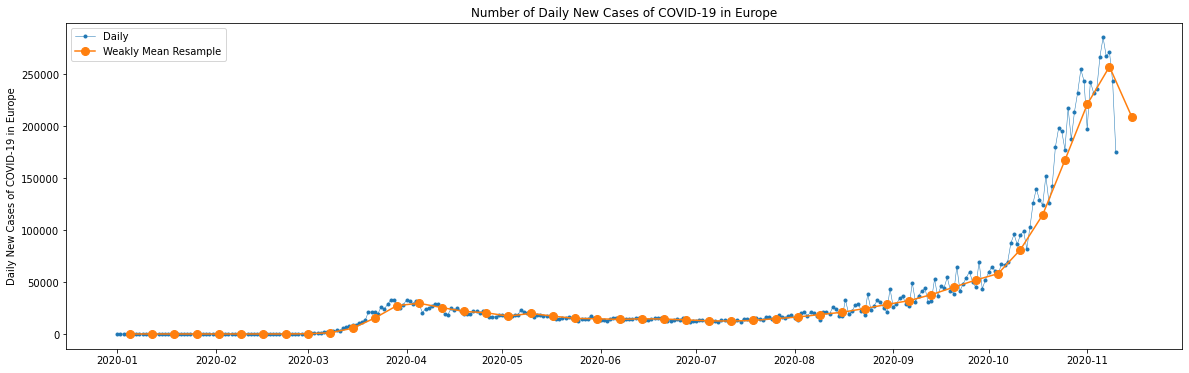

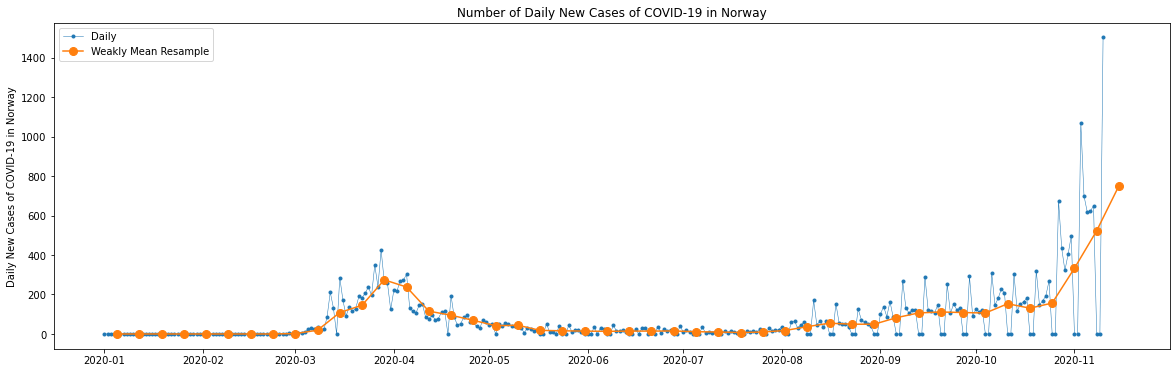

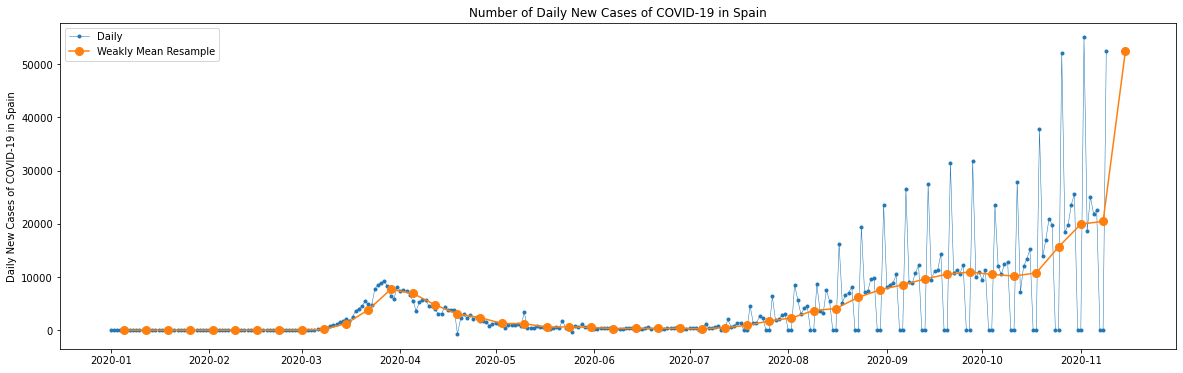

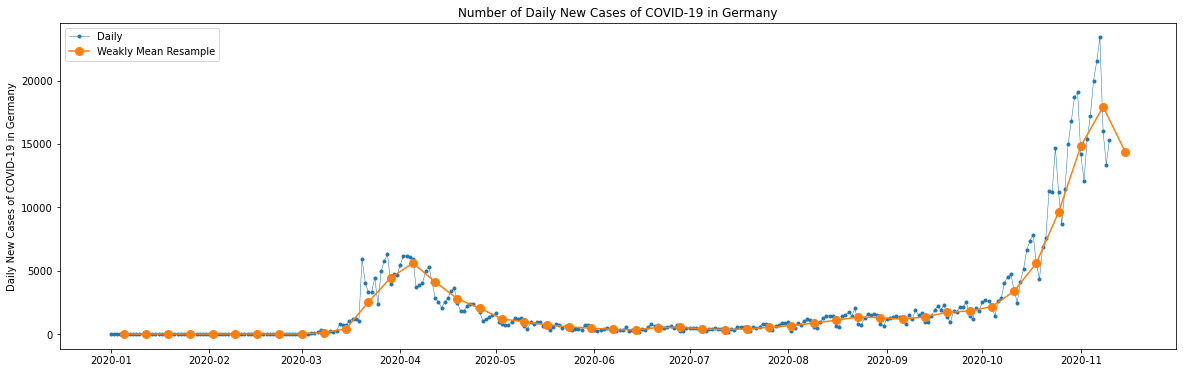

In [231]:
Initial_plot(df_eu)
Initial_plot(df_nor, country_name = 'Norway')
Initial_plot(df_esp, country_name = 'Spain')
Initial_plot(df_deu, country_name = 'Germany')

### Decomposing the data

Into Trend, Season and Residual

In [232]:
def seasonal_decompose(y, country_name ='Europe'):
    """For specific country.
    :param y: dataseries
    :param country_name: for the heading  
    """
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,14)
    fig.suptitle("Decomposition of the Time Series of COVID-19 Cases in " + country_name, fontsize=16)
    plt.show()


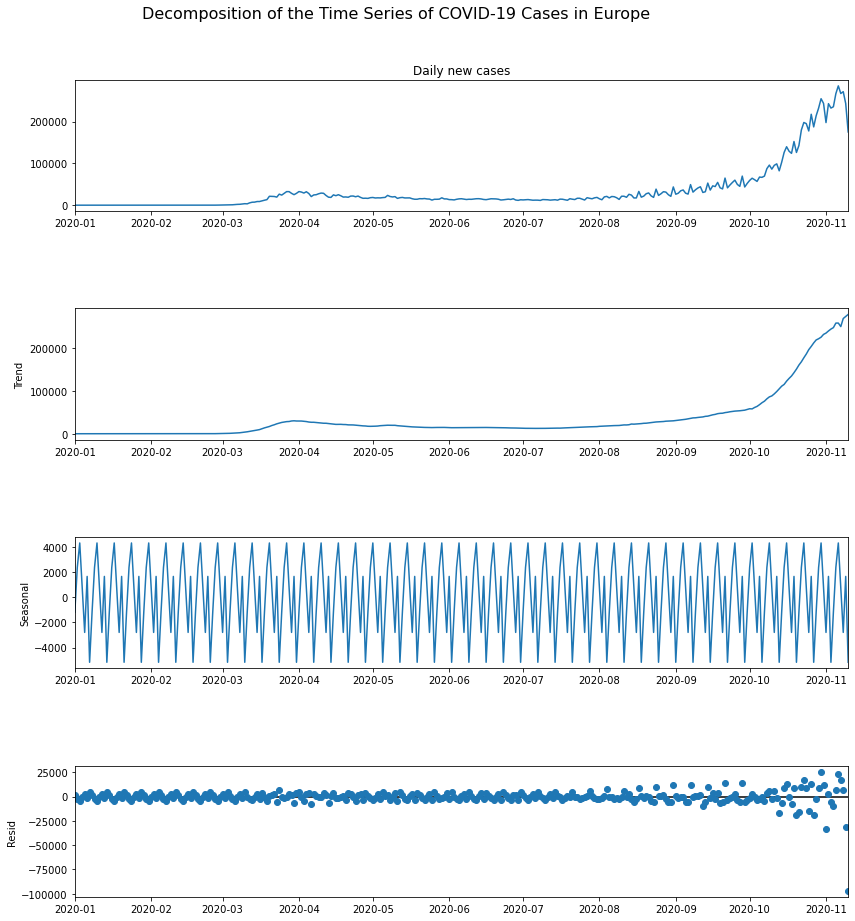

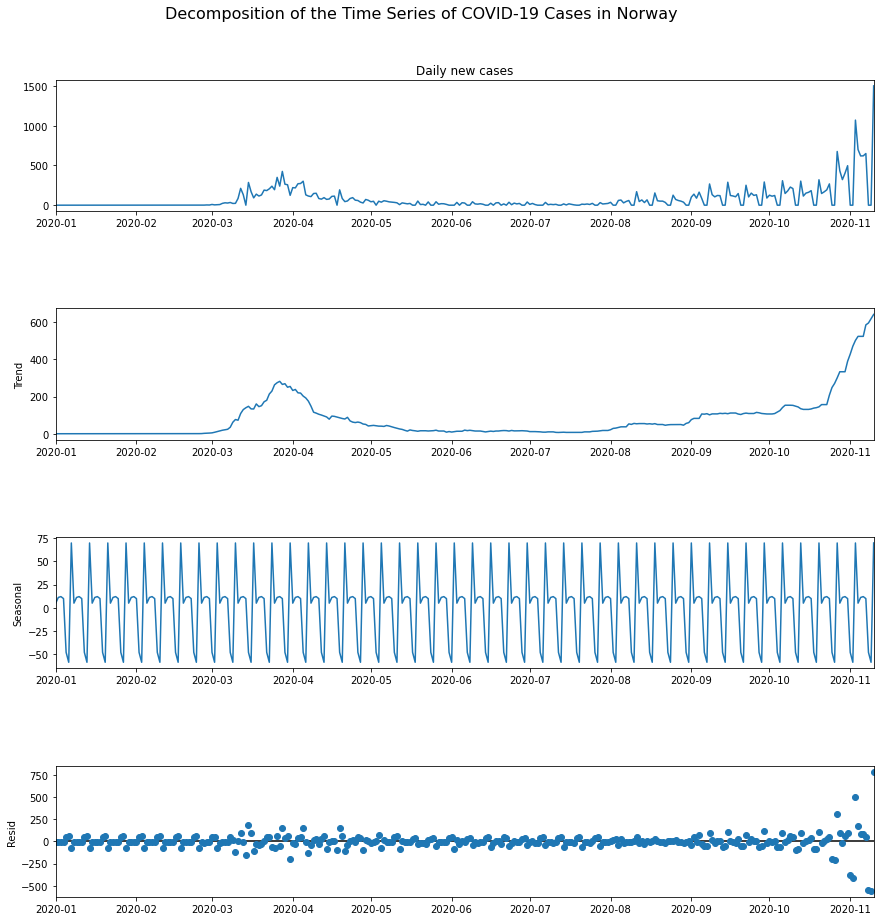

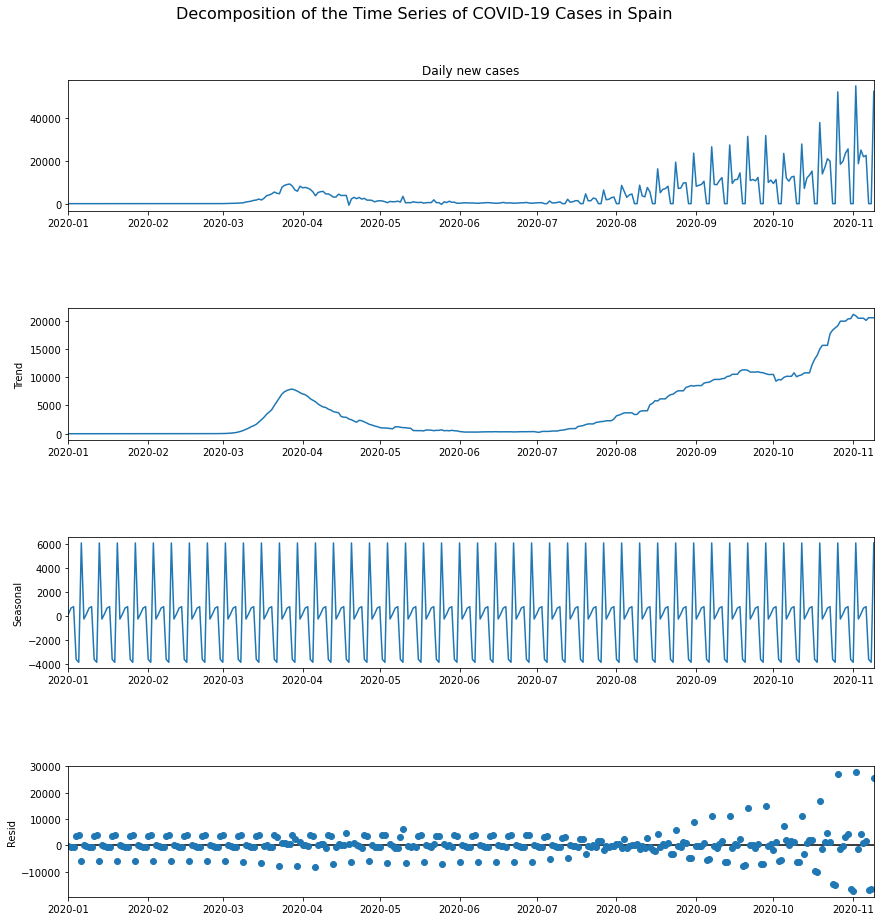

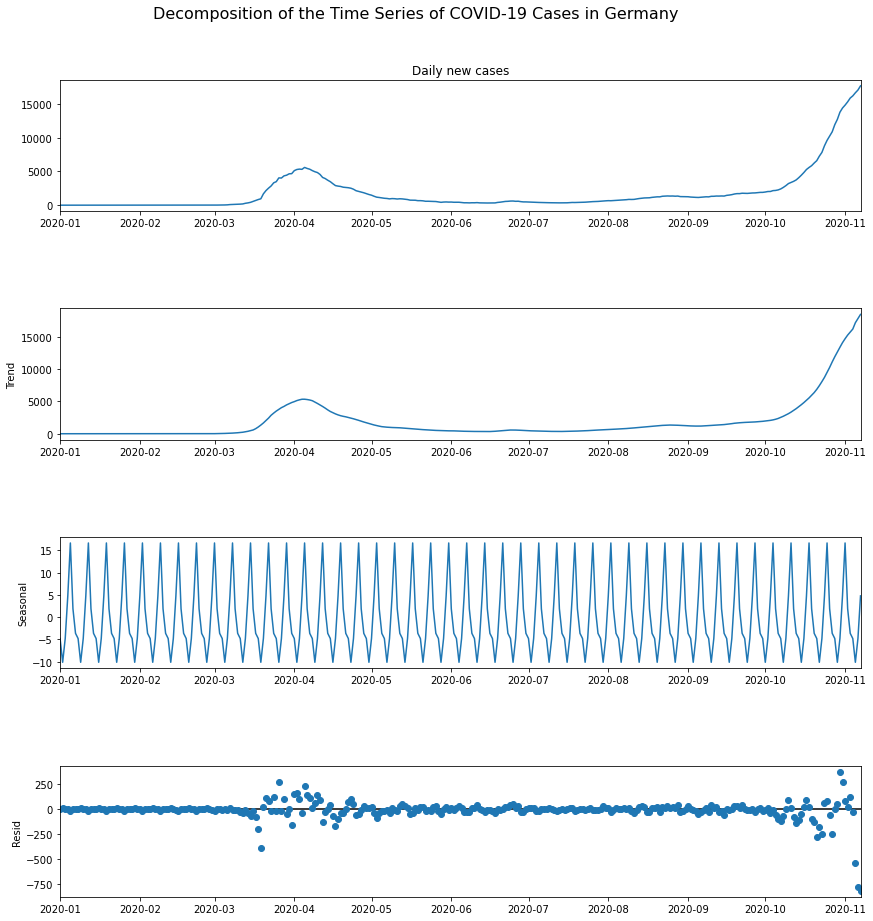

In [233]:
y_eu = df_eu['new_cases'].rename("Daily new cases")
y_nor = df_nor['new_cases'].rename("Daily new cases")
y_esp = df_esp['new_cases'].rename("Daily new cases")
y_ger = df_ger['new_cases'].rename("Daily new cases")

seasonal_decompose(y_eu)
seasonal_decompose(y_nor, country_name ='Norway')
seasonal_decompose(y_esp, country_name ='Spain')
seasonal_decompose(y_ger, country_name ='Germany')


## Creating Forecasts

In [234]:
    
def europe_forecasts(smoothed = False, \
                     s_date='2020-01-01',train_e_date='2020-10-31', test_s_date = '2020-11-01', e_date='2020-11-07'):
    """Creating forecasts for entire Europe.
    ES methods: Holt Linear, Holt-Winters-Additive and Holt-Winters-Additive Dampened
    
    :param smoothed: True->Uses new_cases_smoothed as the source for new cases (7-day average)
                     False->Uses raw data from new_cases
    :param s_date: beginning of the entire dataset
    :param train_e_date: ending of training part of the set
    :param test_s_date: start of test part of set
    :param e_date: end of the entire dataset
    
    :return y: Pandas Series containing the actual reported data
    :return *method*_forecast: Pandas Series containing the forecast based on the given method
    :return results:Dataframe containing hyperparameters and error
    """
    
    df = europe_set(smoothed = smoothed, end_date=e_date) #SJEKK
    #if (smoothed):
    #    df = Europe_set(smoothed = True, end_date=e_date)
    #else: 
    #    df = Europe_set(end_date=e_date)
        
    name = "Europe"
        
    y = df['new_cases'].rename('Actual Reported Data')
    y = y[s_date:]
    y_to_train = y[:train_e_date]
        
    # dataset to train
    y_to_test = y[test_s_date:] # last X months for test
    predict_date = len(y) - len(y_to_train) 
    
    #Holt Linear
    holt_lin_fit = Holt(y_to_train).fit(optimized=True)
    holt_lin_forecast = holt_lin_fit.forecast(predict_date).rename("Holt's Linear")
    mae_holt_lin = abs(holt_lin_forecast - y_to_test).mean()
    
    #Holt-Winters-Additive
    holtw_ad_fit = ExponentialSmoothing(y_to_train, seasonal_periods=7, trend='add', seasonal='add').fit(optimized=True)
    holtw_ad_forecast = holtw_ad_fit.forecast(predict_date).rename("Holt-Winter's Additive")
    mae_holtw_ad = abs(holtw_ad_forecast - y_to_test).mean()
    
    #Holt-Winters-Additive Dampened
    holtw_ad_damp_fit = ExponentialSmoothing(y_to_train, seasonal_periods = 7, trend='add', seasonal='add', damped=True).fit(optimized=True)
    holtw_ad_damp_forecast = holtw_ad_damp_fit.forecast(predict_date).rename("Holt-Winter's Additive+Damped")
    mae_holtw_ad_damp = abs(holtw_ad_damp_forecast - y_to_test).mean()
    
    params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'initial_level', 'initial_trend', 'smoothing_seasonal']
    results=pd.DataFrame(index=[r"Smooth. Lvl ($\alpha$)",r"Smooth. Trend ($\beta$)",r"Damp. Trend ($\phi$)",\
                                r"Initial Lvel ($l_0)$","Initial Trend ($b_0)$",r"Season Smoothing ($\gamma$)",\
                                "Mean Absolute Error"] ,\
                         columns=["Holt's Linear","Holt-Winter's Additive","Holt-Winter's Additive + Damped"])
    results["Holt's Linear"] = [format(holt_lin_fit.params[p],".2f") for p in params] + [format(mae_holt_lin, ".2f")]
    results["Holt-Winter's Additive"] = [format(holtw_ad_fit.params[p],".2f") for p in params] + [format(mae_holtw_ad, ".2f")]
    results["Holt-Winter's Additive + Damped"] = [format(holtw_ad_damp_fit.params[p],".2f") for p in params] + [format(mae_holtw_ad_damp, ".2f")]
    
    return y, holt_lin_forecast, holtw_ad_forecast, holtw_ad_damp_forecast, results

In [235]:
        
def country_forecasts(iso_cd = None, smoothed = False, \
                      s_date='2020-01-01',train_e_date='2020-10-31', test_s_date = '2020-11-01', e_date='2020-11-07'):
    """Creating forecasts for specific country.
    ES methods: Holt Linear, Holt-Winters-Additive and Holt-Winters-Additive Dampened
    
    :param iso_code: The county's ISO-code (3 letters)
    :param smoothed: True->Uses new_cases_smoothed as the source for new cases (7-day average)
                     False->Uses raw data from new_cases
    :param s_date: beginning of the entire dataset
    :param train_e_date: ending of training part of the set
    :param test_s_date: start of test part of set
    :param e_date: end of the entire dataset
    
    :return y: Pandas Series containing the actual reported data
    :return *method*_forecast: Pandas Series containing the forecast based on the given method
    :return results:Dataframe containing hyperparameters and error
    """
    df = country_set(smoothed=smoothed, iso_code=iso_cd, end_date=e_date)
    
    name = iso_cd
        
    y = df['new_cases'].rename('Actual Reported Data')
    y = y[s_date:]
    y_to_train = y[:train_e_date]
    
    # dataset to train
    y_to_test = y[test_s_date:] # last X months for test
    predict_date = len(y) - len(y_to_train) 
    
    #Holt Linear
    holt_lin_fit = Holt(y_to_train).fit(optimized=True)
    holt_lin_forecast = holt_lin_fit.forecast(predict_date).rename("Holt's Linear")
    mae_holt_lin = abs(holt_lin_forecast - y_to_test).mean()
    
    #Holt-Winters-Additive
    holtw_ad_fit = ExponentialSmoothing(y_to_train, seasonal_periods=7, trend='add', seasonal='add').fit(optimized=True)
    holtw_ad_forecast = holtw_ad_fit.forecast(predict_date).rename("Holt-Winter's Additive")
    mae_holtw_ad = abs(holtw_ad_forecast - y_to_test).mean()
    
    #Holt-Winters-Additive Dampened
    holtw_ad_damp_fit = ExponentialSmoothing(y_to_train, seasonal_periods = 7, trend='add', seasonal='add', damped=True).fit(optimized=True)
    holtw_ad_damp_forecast = holtw_ad_damp_fit.forecast(predict_date).rename("Holt-Winter's Additive+Damped")
    mae_holtw_ad_damp = abs(holtw_ad_damp_forecast - y_to_test).mean()
    
    params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'initial_level', 'initial_trend', 'smoothing_seasonal']
    results=pd.DataFrame(index=[r"Smooth. Lvl ($\alpha$)",r"Smooth. Trend ($\beta$)",r"Damp. Trend ($\phi$)",\
                                r"Initial Lvel ($l_0)$","Initial Trend ($b_0)$",r"Season Smoothing ($\gamma$)",\
                                "Mean Absolute Error"] ,\
                         columns=["Holt's Linear","Holt-Winter's Additive","Holt-Winter's Additive + Damped"])
    results["Holt's Linear"] = [format(holt_lin_fit.params[p],".2f") for p in params] + [format(mae_holt_lin, ".2f")]
    results["Holt-Winter's Additive"] = [format(holtw_ad_fit.params[p],".2f") for p in params] + [format(mae_holtw_ad, ".2f")]
    results["Holt-Winter's Additive + Damped"] = [format(holtw_ad_damp_fit.params[p],".2f") for p in params] + [format(mae_holtw_ad_damp, ".2f")]
    
    return y, holt_lin_forecast, holtw_ad_forecast, holtw_ad_damp_forecast, results
    

## Plotting Forecasts

In [236]:

def plot_methods(iso_code=None, smoothed=False, s_date='2020-01-01',train_e_date='2020-10-31',\
                 test_s_date = '2020-11-01', e_date='2020-11-07', plot_start = '2020-10-10'):
    """Plotting the different forecasting methods.
    ES methods: Holt Linear, Holt-Winters-Additive and Holt-Winters-Additive Dampened
    
    :param iso_code: The county's ISO-code (3 letters)
    :param smoothed: True->Uses new_cases_smoothed as the source for new cases (7-day average)
                     False->Uses raw data from new_cases
    :param s_date: beginning of the entire dataset
    :param train_e_date: ending of training part of the set
    :param test_s_date: start of test part of set
    :param e_date: end of the entire dataset
    :param plot_start: start of plot
    """
    
    if (iso_code==None):
        y, holt_lin_forecast,\
        holtw_ad_forecast, \
        holtw_ad_damp_forecast, \
        results = europe_forecasts(smoothed=smoothed, \
                                   s_date=s_date,train_e_date=train_e_date, test_s_date=test_s_date, e_date=e_date)
        name = "Europe"
    else:
        y, holt_lin_forecast,\
        holtw_ad_forecast, \
        holtw_ad_damp_forecast, \
        results = country_forecasts(iso_cd=iso_code, smoothed=smoothed, \
                                    s_date=s_date,train_e_date=train_e_date, test_s_date=test_s_date, e_date=e_date)
        name = iso_code  
                
    y.plot(marker='o', color='black', legend="Actual Number of Cases", figsize=(14, 7), xlim=(plot_start,e_date))
        
    holt_lin_forecast.plot(style='--', marker='o', color='red', legend=True, xlim=(plot_start,e_date))
    holtw_ad_forecast.plot(style='--', marker='o', color='green', legend=True, xlim=(plot_start,e_date))
    holtw_ad_damp_forecast.plot(style='--', marker='o', color='blue', legend=True, xlim=(plot_start,e_date))
        
    plt.title("Comparison of different forecasting methods - "+name)
    plt.ylim(0, None)
    plt.axvspan(test_s_date, '2020-11-08' , alpha=0.1, color='grey' )
    plt.ylabel("Daily new COVID-19 cases")
    plt.xlabel("Date")
        
    display(results)
    

,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),0.24,0.29,0.29
Smooth. Trend ($\beta$),0.24,0.29,0.29
Damp. Trend ($\phi$),nan,nan,0.99
Initial Lvel ($l_0)$,0.00,26641.55,26641.55
Initial Trend ($b_0)$,0.00,0.00,0.00
Season Smoothing ($\gamma$),nan,0.53,0.56
Mean Absolute Error,38318.71,23161.39,20156.53


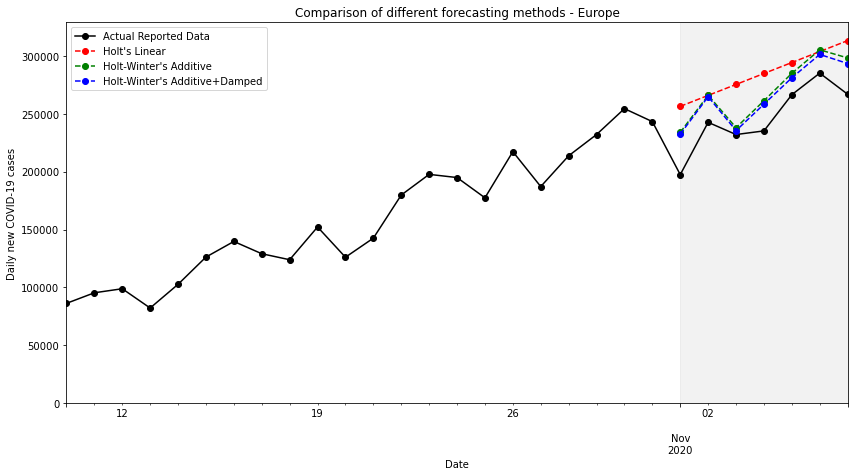

In [237]:
plot_methods(smoothed=False)

,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),0.78,0.78,0.78
Smooth. Trend ($\beta$),0.74,0.71,0.75
Damp. Trend ($\phi$),nan,nan,0.99
Initial Lvel ($l_0)$,0.00,25568.57,25568.40
Initial Trend ($b_0)$,0.00,-0.03,0.00
Season Smoothing ($\gamma$),nan,0.00,0.00
Mean Absolute Error,13647.05,13718.60,12598.64


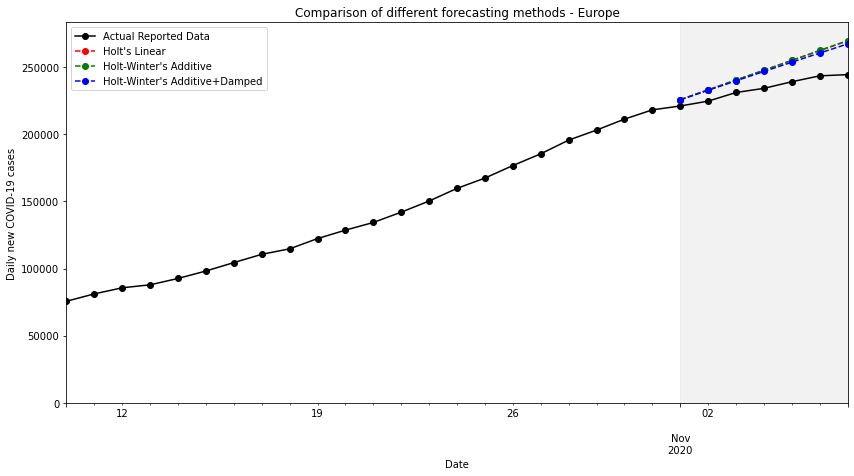

In [238]:
plot_methods(smoothed=True)

,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),0.20,0.34,0.27
Smooth. Trend ($\beta$),0.18,0.00,0.16
Damp. Trend ($\phi$),nan,nan,0.87
Initial Lvel ($l_0)$,0.06,60.87,64.10
Initial Trend ($b_0)$,-0.01,1.36,0.11
Season Smoothing ($\gamma$),nan,0.37,0.36
Mean Absolute Error,263.97,247.49,216.32


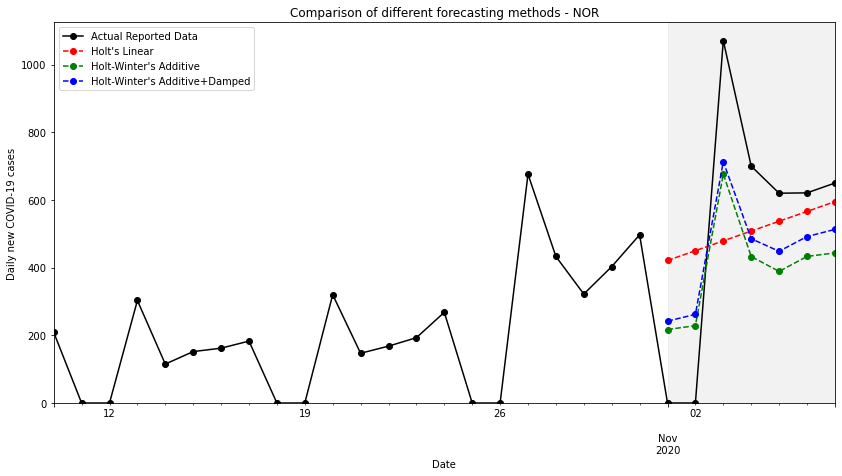

In [239]:
plot_methods('NOR', smoothed=False)

,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),0.92,0.92,0.83
Smooth. Trend ($\beta$),0.40,0.41,0.59
Damp. Trend ($\phi$),nan,nan,0.87
Initial Lvel ($l_0)$,0.00,59.15,59.23
Initial Trend ($b_0)$,0.00,0.08,0.05
Season Smoothing ($\gamma$),nan,0.00,0.00
Mean Absolute Error,26.90,26.23,39.18


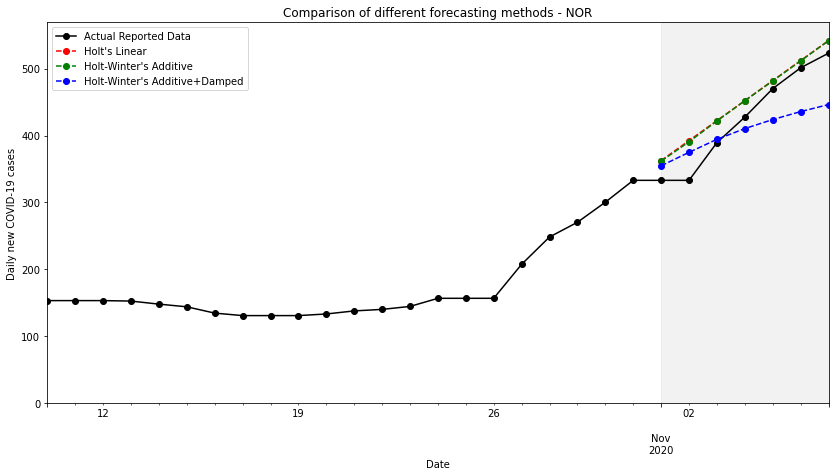

In [240]:
plot_methods('NOR', smoothed=True)

,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),0.08,0.15,0.15
Smooth. Trend ($\beta$),0.03,0.15,0.15
Damp. Trend ($\phi$),nan,nan,0.99
Initial Lvel ($l_0)$,0.00,3929.45,3929.45
Initial Trend ($b_0)$,0.00,0.00,0.00
Season Smoothing ($\gamma$),nan,0.85,0.85
Mean Absolute Error,12921.66,3845.33,3656.58


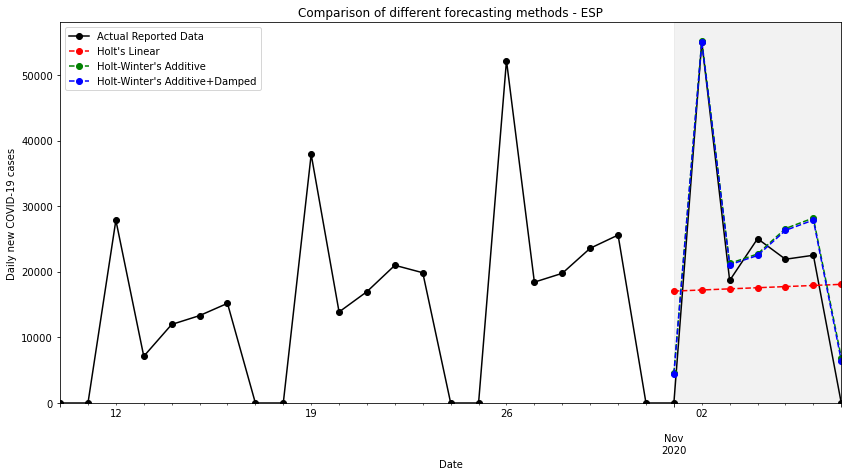

In [241]:
plot_methods('ESP', smoothed=False)

,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),0.95,0.91,0.91
Smooth. Trend ($\beta$),0.28,0.27,0.27
Damp. Trend ($\phi$),nan,nan,0.99
Initial Lvel ($l_0)$,0.00,3689.39,3689.35
Initial Trend ($b_0)$,0.00,2.48,2.36
Season Smoothing ($\gamma$),nan,0.08,0.08
Mean Absolute Error,1396.22,1756.37,1625.09


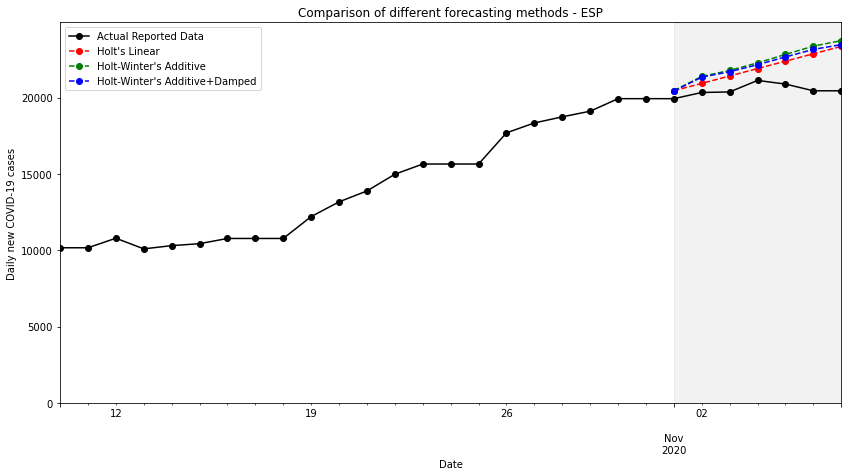

In [242]:
plot_methods('ESP', smoothed=True)

,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),0.97,0.25,0.25
Smooth. Trend ($\beta$),0.03,0.25,0.25
Damp. Trend ($\phi$),nan,nan,0.99
Initial Lvel ($l_0)$,-0.06,1579.36,1579.36
Initial Trend ($b_0)$,2.51,0.00,0.00
Season Smoothing ($\gamma$),nan,0.54,0.54
Mean Absolute Error,3431.23,2630.28,2357.00


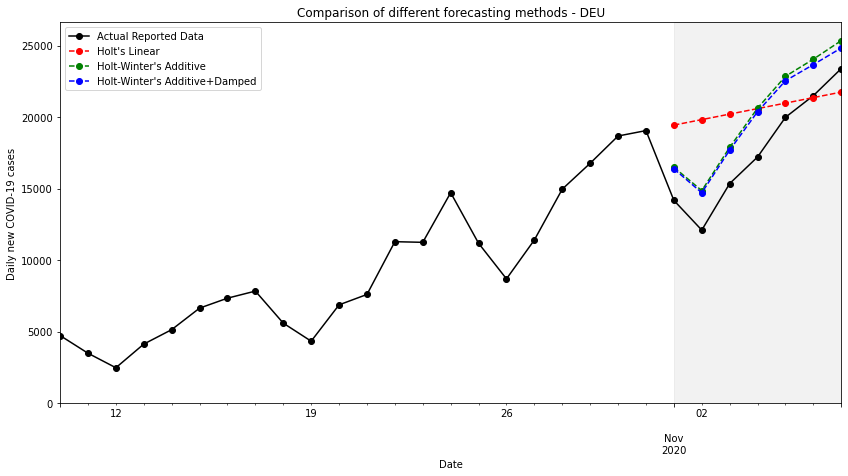

In [243]:
plot_methods('DEU', smoothed=False)

,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),0.83,0.81,0.82
Smooth. Trend ($\beta$),0.60,0.62,0.63
Damp. Trend ($\phi$),nan,nan,0.99
Initial Lvel ($l_0)$,0.00,1507.87,1507.58
Initial Trend ($b_0)$,0.00,-0.00,0.01
Season Smoothing ($\gamma$),nan,0.00,0.00
Mean Absolute Error,1443.24,1411.50,1275.64


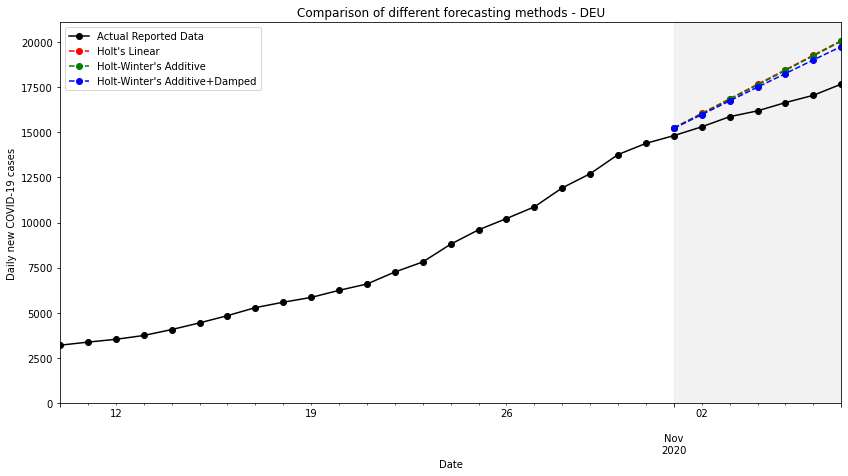

In [244]:
plot_methods('DEU', smoothed=True)